In [1]:
# import packages packages
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import Background2D, MedianBackground
from photutils import detect_threshold, detect_sources, deblend_sources
from photutils import source_properties
from photutils import EllipticalAperture
from sklearn import preprocessing
from skimage.measure import compare_ssim as ssim
#%matplotlib inline

In [2]:
# load image data
file_list = glob.glob("/Users/yifei-wang/Desktop/Biofilm/Data/Biofilm181205_Z1/*.tif")
# sort image in order
file_list.sort()

In [3]:
# print file list
file_list

['/Users/yifei-wang/Desktop/Biofilm/Data/Biofilm181205_Z1/Biofilm181205-Z001C2T01.tif',
 '/Users/yifei-wang/Desktop/Biofilm/Data/Biofilm181205_Z1/Biofilm181205-Z001C2T02.tif',
 '/Users/yifei-wang/Desktop/Biofilm/Data/Biofilm181205_Z1/Biofilm181205-Z001C2T03.tif',
 '/Users/yifei-wang/Desktop/Biofilm/Data/Biofilm181205_Z1/Biofilm181205-Z001C2T04.tif',
 '/Users/yifei-wang/Desktop/Biofilm/Data/Biofilm181205_Z1/Biofilm181205-Z001C2T05.tif',
 '/Users/yifei-wang/Desktop/Biofilm/Data/Biofilm181205_Z1/Biofilm181205-Z001C2T06.tif',
 '/Users/yifei-wang/Desktop/Biofilm/Data/Biofilm181205_Z1/Biofilm181205-Z001C2T07.tif',
 '/Users/yifei-wang/Desktop/Biofilm/Data/Biofilm181205_Z1/Biofilm181205-Z001C2T08.tif',
 '/Users/yifei-wang/Desktop/Biofilm/Data/Biofilm181205_Z1/Biofilm181205-Z001C2T09.tif',
 '/Users/yifei-wang/Desktop/Biofilm/Data/Biofilm181205_Z1/Biofilm181205-Z001C2T10.tif',
 '/Users/yifei-wang/Desktop/Biofilm/Data/Biofilm181205_Z1/Biofilm181205-Z001C2T11.tif',
 '/Users/yifei-wang/Desktop/Biof

In [4]:
# load image
data = plt.imread(file_list[0])

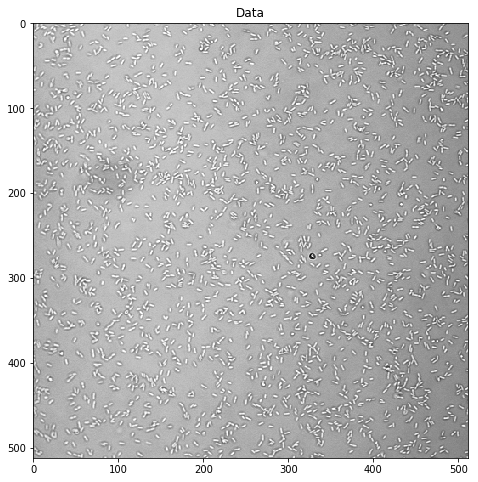

In [5]:
# show image
plt.figure(figsize=(8,8))
plt.imshow(data, cmap='Greys_r')
plt.title('Data')
plt.show()

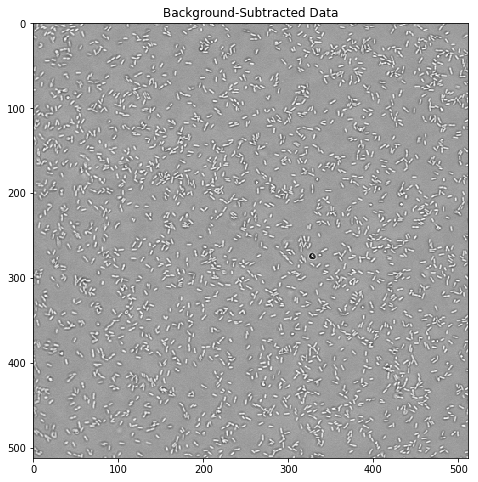

In [6]:
# define background estimator
# MeanBackground
# MedianBackground
# ModeEstimatorBackground
# MMMBackground
# SExtractorBackground
# BiweightLocationBackground
bkg_estimator = MedianBackground()
# estimate background (background or the background noise varies across the image)
box_size = (10, 10)
filter_size= (3, 3)
bkg = Background2D(data, box_size, filter_size=filter_size, bkg_estimator=bkg_estimator)
# show background-subtracted image:
plt.figure(figsize=(8,8))
plt.imshow(data - bkg.background, cmap='Greys_r')
plt.title('Background-Subtracted Data')
plt.show()

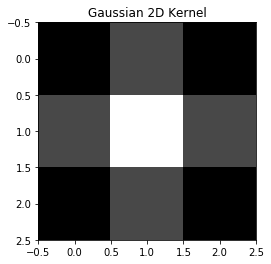

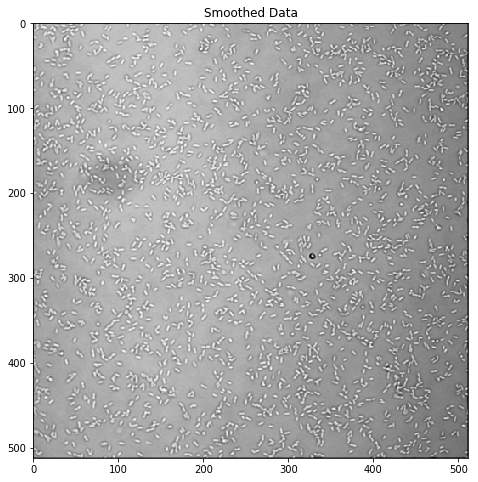

In [7]:
# calculate threshold image that can be used to detect sources
threshold = bkg.background + (1.5 * bkg.background_rms)
# smooth the image with a 2D circular Gaussian kernel with a FWHM of 3 pixels
sigma = 1.5 * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
# show Gaussian2DKernel
plt.imshow(kernel, interpolation='none', cmap='Greys_r')
plt.title('Gaussian 2D Kernel')
plt.show()
# smooth the image
from astropy.convolution import *
smoothed_data = convolve(data, kernel)
# show smoothed image
plt.figure(figsize=(8,8))
plt.imshow(smoothed_data, cmap='Greys_r')
plt.title('Smoothed Data')
plt.show()

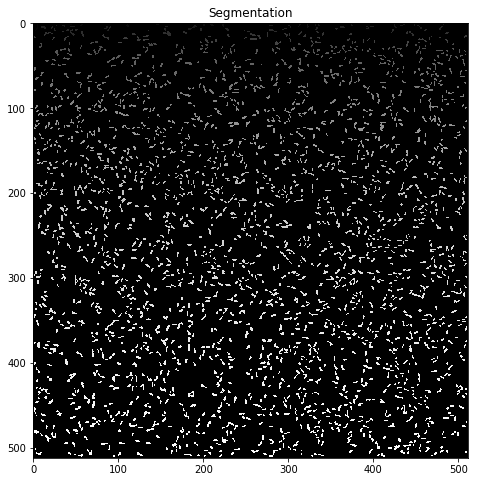

In [8]:
# find sources that have 5 connected pixels 
# that are each greater than the corresponding 
# pixel-wise threshold level defined above
npixels = 3
# detect sources above the threshold and return a SegmentationImage object
segm = detect_sources(data, threshold, npixels=npixels, filter_kernel=kernel)
# show segmentation image
plt.figure(figsize=(8,8))
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(segm, cmap='Greys_r', norm=norm)
plt.title('Segmentation')
plt.show()

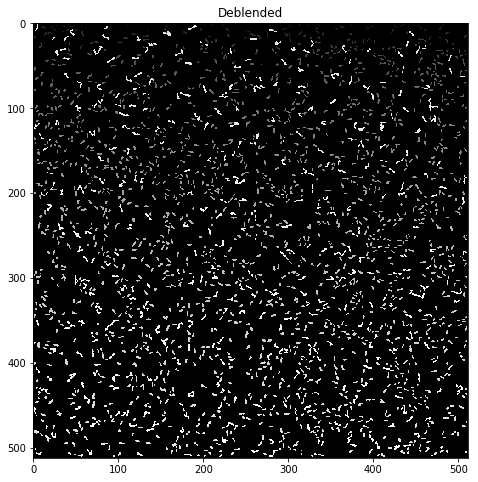

In [9]:
# deblend overlapping sources labeled in a segmentation image
segm_deblend = deblend_sources(data, segm, npixels=npixels, filter_kernel=kernel, nlevels=10, contrast=0.01)
# show deblend image
plt.figure(figsize=(8,8))
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(segm_deblend, cmap='Greys_r', norm=norm)
plt.title('Deblended')
plt.show()

In [10]:
# calculate photometry and morphological properties of sources
cat = source_properties(data, segm_deblend)

In [11]:
# estimate centers of elliptical aperture
r = 2.
apertures = []
for obj in cat:
    position = (obj.xcentroid.value, obj.ycentroid.value)
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

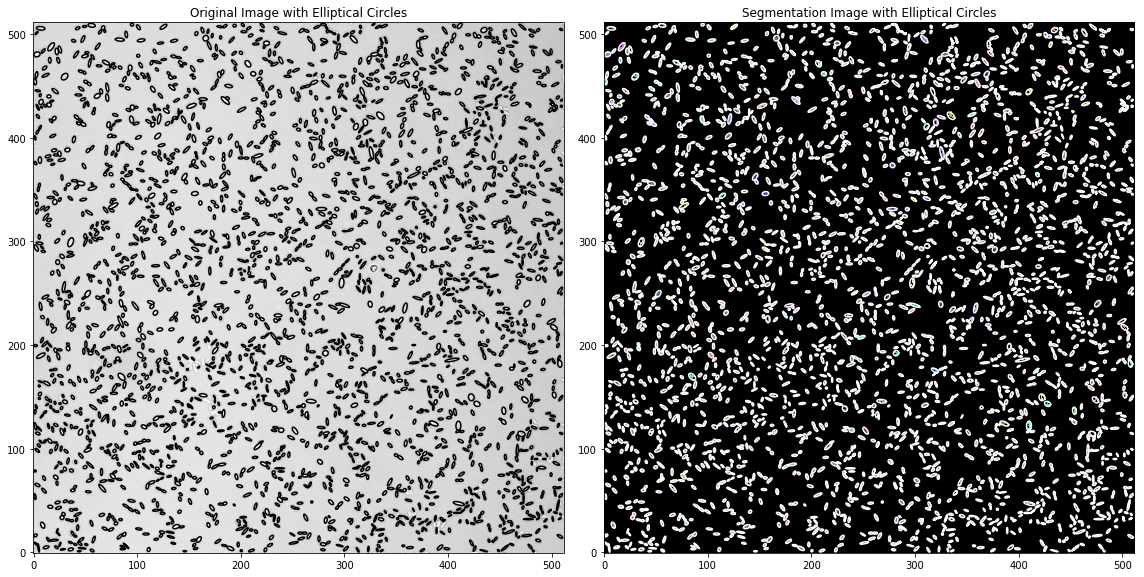

In [12]:
# show images with elliptical circles  
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Original Image with Elliptical Circles')
ax2.imshow(segm, origin='lower', cmap=segm.cmap(random_state=12345))
ax2.set_title('Segmentation Image with Elliptical Circles')
for aperture in apertures:
    aperture.plot(color='black', lw=1.5, ax=ax1)
    aperture.plot(color='white', lw=1.5, ax=ax2)
plt.tight_layout()

In [13]:
# calcuate Moran's I spatial auto-correlation
Moran = np.zeros(shape=(len(file_list)-1,1))
for n in range(0,len(file_list)-1):
    # load data, starting from second image
    data = plt.imread(file_list[n+1])
    # esitmate background
    bkg = Background2D(data, box_size, filter_size=filter_size, bkg_estimator=bkg_estimator)
    # calculate threshold
    threshold = bkg.background + (1.5 * bkg.background_rms)
    # generate segmentation
    segm = detect_sources(data, threshold, npixels=npixels, filter_kernel=kernel)
    # AVOIDE 
    # deblend overlapping sources labeled in a segmentation image
    # segm_deblend = deblend_sources(data, segm, npixels=npixels, filter_kernel=kernel, nlevels=10, contrast=0.01)
    # calculate photometry and morphological properties of sources
    cat = source_properties(data, segm)
    apertures = []
    for obj in cat:
        position = (obj.xcentroid.value, obj.ycentroid.value)
        a = obj.semimajor_axis_sigma.value * r
        b = obj.semiminor_axis_sigma.value * r
        theta = obj.orientation.value
        apertures.append(EllipticalAperture(position, a, b, theta=theta))
    # calculate cell positions
    cell_position = np.array([cat.xcentroid.value,cat.ycentroid.value])
    # calculate number of spatial units
    N = len(cell_position[0,:])
    # calculate weight matrix based on Euclidean distance
    W = np.zeros(shape=(N,N))
    for i in range(N):
        for j in range(i+1,N):
            W[i,j] = 1/np.sqrt(sum(np.square((cell_position[:,i]-cell_position[:,j]))))
            W[j,i] = W[i,j]
    # row standardization
    norm_W = preprocessing.normalize(W, norm='l2')**2
    # get value from image data
    val_Data = np.zeros(shape=(N,1))
    for i in range(N):
        x = int(np.ceil(cell_position[0,i]))
        if x>=len(data[0,:]):
            x = len(data[0,:])-1
        if x<=0:
            x = 0
        y = int(np.ceil(cell_position[1,i]))
        if y>=len(data[:,0]):
            y = len(data[:,0])-1
        if y<=0:
            y = 0
        val_Data[i] = data[x,y]
    # caculate Moran's I
    temp = 0
    for i in range(N):
        for j in range(i+1,N):
            temp = temp + norm_W[i,j]*(val_Data[i]-val_Data.mean())*(val_Data[j]-val_Data.mean())
    Moran[n] = N/sum(sum(norm_W))*temp*2/sum(np.square(val_Data-val_Data.mean()))

In [14]:
# calculate structural similarity between two images (t,t+1)
SSIM = np.zeros(shape=(len(file_list)-1,1))
for n in range(len(file_list)-1):
    SSIM[n]= ssim(plt.imread(file_list[n]), plt.imread(file_list[n+1]))

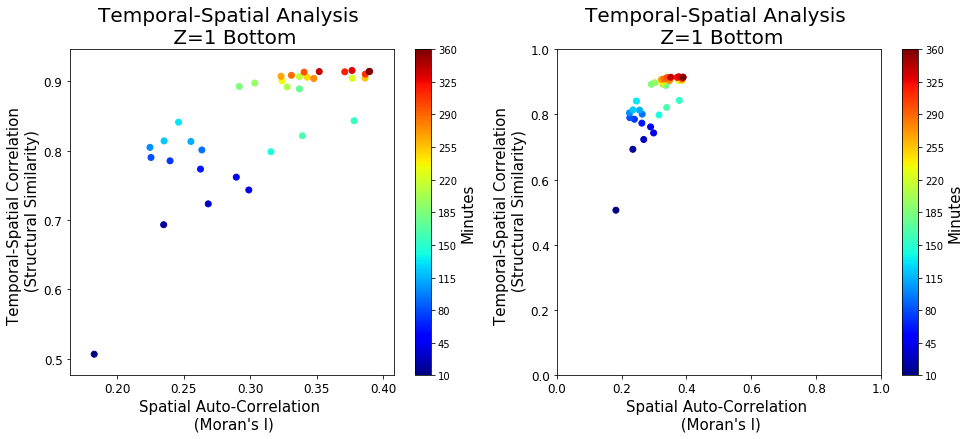

In [17]:
import matplotlib.cm as cm
import matplotlib.colorbar as cb
# plot figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
colors = cm.jet(np.linspace(0, 1, len(SSIM)))
cmap = cm.get_cmap('jet')
# subplot 1
im1 = ax1.scatter(Moran, SSIM, color=colors, marker='o',cmap='jet')
ax1.set_xlabel('Spatial Auto-Correlation \n (Moran\'s I)',fontsize=15)
ax1.set_ylabel('Temporal-Spatial Correlation \n (Structural Similarity)',fontsize=15)
ax1.set_title('Temporal-Spatial Analysis \n Z=1 Bottom',fontsize=20)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)
cax1, _ = cb.make_axes(ax1)
cbar1 = cb.ColorbarBase(cax1, cmap=cmap)
cbar1.set_label('Minutes',fontsize=15)
cbar1.set_ticks(np.arange(0, 1.1, step=0.1))
cbar1.set_ticklabels(['10','45','80','115','150','185','220','255','290','325','360'])
# subplot 2
im2 = ax2.scatter(Moran, SSIM, color=colors, marker='o',cmap='jet')
ax2.set_xlabel('Spatial Auto-Correlation \n (Moran\'s I)',fontsize=15)
ax2.set_ylabel('Temporal-Spatial Correlation \n (Structural Similarity)',fontsize=15)
ax2.set_title('Temporal-Spatial Analysis \n Z=1 Bottom',fontsize=20)
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
cax2, _ = cb.make_axes(ax2)
cbar2 = cb.ColorbarBase(cax2, cmap=cmap)
cbar2.set_label('Minutes',fontsize=15)
cbar2.set_ticks(np.arange(0, 1.1, step=0.1))
cbar2.set_ticklabels(['10','45','80','115','150','185','220','255','290','325','360'])
plt.show() 
fig.savefig('Results.jpg')